## import modules

In [4]:
import torch
import torch.nn as nn  # weight값이 있는 것들
import torch.nn.functional as F # weight값이 없는 것들, pooling, activation func
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
!pip install torchvision

## define model architecture

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x): # Feature Extraction
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        print(x.shape)         ### flatten 할 때, shape을 알아보기 위함
        # Fully Connected (Classification)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## define training and inference routines

In [7]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))


In [11]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

    # with torch.no_grad():
    #     for X, Y in test_dataloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
    #         # image is already size of (28x28), no reshape
    #         # label is not one-hot encoded
    #         X = X.to(device)
    #         Y = Y.to(device)

    #         X, y = X.to(device), y.to(device)
    #         pred_prob = model(X)
    #         loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
    #         pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
    #         success += pred.eq(y.view_as(pred)).sum().item()


    
    # X_test = test_dataloader.test_data.view(len(test_dataloader), 1, 28, 28).float().to(device)
    # Y_test = test_dataloader.test_labels.to(device)

    # prediction = model(X_test)
    # correct_prediction = torch.argmax(prediction, 1) == Y_test
    # accuracy = correct_prediction.float().mean()
    # print('Accuracy:', accuracy.item())



## create data loaders

In [12]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=True)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




71.5%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## define optimizer and run training epochs

In [13]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.5)

## model training

In [14]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

torch.Size([32, 32, 12, 12])
epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])


c:\ITstudy\TechSeminar_03\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([32, 32, 12, 12])
epoch: 1 [320/60000 (1%)]	 training loss: 3.208426
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
epoch: 1 [640/60000 (1%)]	 training loss: 2.442744
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
epoch: 1 [960/60000 (2%)]	 training loss: 2.431488
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.Size([32, 32, 12, 12])
torch.

## run inference on trained model

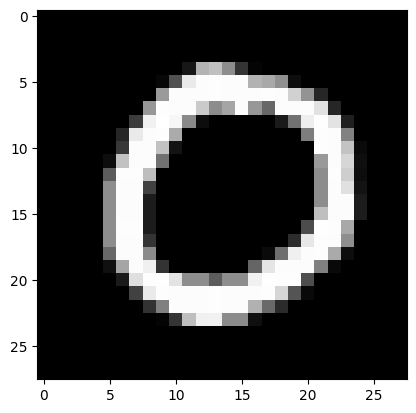

In [15]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [16]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

torch.Size([500, 32, 12, 12])
Model prediction is : 1
Ground truth is : 0


c:\ITstudy\TechSeminar_03\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [17]:
PATH_TO_MODEL = "./convnet.pth"
torch.save(model.state_dict(), PATH_TO_MODEL)